## Viewability Optimierung
As with the "test.ipynb" notebook, the idea here is to use the sklearn decision tree to generate a **Bonsai** tree for Xandr. 

My initial idea here is to optimise the viewability on the basis of publisherID, and SiteDomain (other features will be neglected for now)

*Wie beim Notebook „test.ipynb“ besteht die Idee hier darin, den sklearn DecisionTree zu verwenden, um einen **Bonsai**-Tree für Xandr zu generieren.*

*Meine erste Idee hier ist, die Viewability auf Basis von PublisherID und SiteDomain zu optimieren (andere Features werden vorerst vernachlässigt)*

In [1]:
# input libraries
import numpy as np
import pandas as pd
import pylab as pl
import copilot_lib as cpl
import time 

In [2]:
# SQL query for viewability
query = """
    SELECT 
    StandardLog.DeliveryDateID as DeliveryDate,
    StandardLog.PublisherID as PublisherID,
    StandardLog.SiteDomain as SiteDomain,
    sum(StandardLog.IsImp) as Impressions,
    sum(CASE WHEN ViewabilityLog.ViewMeasurable >= 1 THEN 1 ELSE 0 END) as MeasurableImps,
    sum(CASE WHEN ViewabilityLog.Viewable >= 1 THEN 1 ELSE 0 END) as Viewable,
    sum(CASE WHEN ViewabilityLog.ViewDurationGt50pct >= 1 THEN 1 ELSE 0 END) AS Viewability50_1, 
    sum(CASE WHEN ViewabilityLog.ViewDurationGt75pct >= 3. THEN 1 ELSE 0 END) AS Viewability75_3, 
    sum(CASE WHEN ViewabilityLog.ViewDurationEq100pct >= 1 THEN 1 ELSE 0 END) AS Viewability100_1, 
    FROM `sixty-odp-xaxis-prod.APPNEXUS_1393.LOG_STANDARD` as StandardLog
    INNER JOIN `sixty-odp-xaxis-prod.APPNEXUS_1393.LOG_ENHANCED_VIEWABILITY` as ViewabilityLog USING (AuctionId64)
    WHERE StandardLog.DeliveryDateID >= "2022-02-10"
    AND StandardLog.DeliveryDateID <= "2022-02-16"
    AND ViewabilityLog.DeliveryDateID >= "2022-02-10"
    AND ViewabilityLog.DeliveryDateID <= "2022-02-16"
    
    AND StandardLog.InsertionOrderID NOT IN (6765422) # leaving out the Kaufland campaign
    AND StandardLog.IsImp = 1
    AND StandardLog.DeviceType = 1 # Just desktop
    AND StandardLog.MediaType = '1' # DisplayAds
    AND StandardLog.Width = 300 # Half-page-ad
    AND StandardLog.Height = 600
    GROUP BY DeliveryDate, PublisherID, SiteDomain
    ORDER BY DeliveryDate ASC, PublisherID ASC, SiteDomain ASC
"""

In [3]:
# WARNING!! This can be very slow!!!
start_time =time.time()
df = cpl.from_bigquery(query)
end_time = time.time()
print ('Time taken for Query', end_time - start_time)
df.head()

Time taken for Query 4.206638336181641


,DeliveryDate,PublisherID,SiteDomain,Impressions,MeasurableImps,Viewable,Viewability50_1,Viewability75_3,Viewability100_1
0,2022-02-10,0,1UND1.DE,2,2,2,2,1,2
1,2022-02-10,0,AERO.DE,6,5,4,4,4,4
2,2022-02-10,0,ALL-IN.DE,5,5,4,4,4,4
3,2022-02-10,0,ALLGEMEINE-ZEITUNG.DE,1,1,1,1,1,1
4,2022-02-10,0,ARIVA.DE,1,1,0,0,0,0


In [4]:
# If there's already existing data...
#df = pd.read_csv ('OtherCampaigns.csv')
#df.head()

## Schematic
In this notebook, I wish to optimise the "75:3 Viewability %". The KPI to achieve here is 60\% 75:3 viewability. As a first categorical **score**, all combinations that are $> 60\%$ will have a score of **True**, and $<60\%$ will have a score of **False**.

*In diesem Notebook möchte ich die "75:3 Viewability %" optimieren. Der hier zu erreichende KPI ist 60\% 75:3-Viewability. Als erste **Score** haben alle Kombinationen, die $> 60\%$ sind, eine Score von **True** und $<60\%$ eine Punktzahl von **False***.

In [5]:
# New columns and evaluation of the viewability percentages
df['50:1 Viewability %'] =df.Viewability50_1/df.Impressions * 100.
df['75:3 Viewability %'] = df.Viewability75_3/df.Impressions * 100.
df['Score'] = False
# This will produce a warning "SettingWithCopyWarning"
# Needs to be rewritten later
for i in range (len (df)):
    if (df['75:3 Viewability %'][i] > 60.):
        df['Score'][i] = True
    else:
        df['Score'][i] = False

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [6]:
df.head()

,DeliveryDate,PublisherID,SiteDomain,Impressions,MeasurableImps,Viewable,Viewability50_1,Viewability75_3,Viewability100_1,50:1 Viewability %,75:3 Viewability %,Score
0,2022-02-10,0,1UND1.DE,2,2,2,2,1,2,100.000000,50.000000,False
1,2022-02-10,0,AERO.DE,6,5,4,4,4,4,66.666667,66.666667,True
2,2022-02-10,0,ALL-IN.DE,5,5,4,4,4,4,80.000000,80.000000,True
3,2022-02-10,0,ALLGEMEINE-ZEITUNG.DE,1,1,1,1,1,1,100.000000,100.000000,True
4,2022-02-10,0,ARIVA.DE,1,1,0,0,0,0,0.000000,0.000000,False


In [7]:
# Ensure that PublisherID are strings rather than values
df.PublisherID = df.PublisherID.astype(str)
df.dtypes

DeliveryDate           object
PublisherID            object
SiteDomain             object
Impressions             int64
MeasurableImps          int64
Viewable                int64
Viewability50_1         int64
Viewability75_3         int64
Viewability100_1        int64
50:1 Viewability %    float64
75:3 Viewability %    float64
Score                    bool
dtype: object

## Reduction of complexity
Here, the publishers who have $< 0.5\%$ of all  impressions will be set to "other". 

*Hier werden die Publisher, die $< 0.5\%$ aller Impressionen haben, auf "other" gesetzt.*

In [8]:
Imps_by_Publisher= []
unique_publishers = np.unique (df.PublisherID)
for publisher_id in unique_publishers:
    Imps_by_Publisher += [ np.sum (df.Impressions[df.PublisherID == publisher_id])]
Imps_by_Publisher = np.array (Imps_by_Publisher)
Imps_total = np.sum (Imps_by_Publisher)

In [9]:
most_important_publishers = np.argsort (-Imps_by_Publisher)
Imps_ordered =100* Imps_by_Publisher[most_important_publishers]/Imps_total
most_important_publisherID = unique_publishers [most_important_publishers]


In [10]:
# Sanity check of 40 most important publisher IDs
for ID in range (40):
    print (most_important_publisherID[ID], Imps_ordered[ID])

1989822 29.38302369472056
1000494 16.143793581961873
1000533 5.197666724104706
1775869 4.594873196182172
990535 4.390339397634708
1866534 3.2708074394835878
0 3.0056068362822157
1000500 2.8876379405098254
1775886 2.692178672406392
1145257 2.210106987694325
1106811 2.196138328471492
1120688 1.273798975699631
1527735 1.2116027558023466
1703113 1.0894534583647288
990550 1.0620259450001885
1285870 1.0070689572548832
1802193 0.8816569072980637
1454503 0.7317742134472306
1553526 0.723413410116776
1828659 0.6776329138317255
1760703 0.6484720631913594
990551 0.6204327837294689
1000527 0.5869895704076503
1493076 0.5133737166931596
2037059 0.4988952523892015
1800665 0.427624502047887
1000530 0.4255852817233859
1000526 0.42487155460981046
2055024 0.41416564790617955
1468430 0.373483202432382
1573678 0.35513021951187185
1985226 0.34778902634366776
1888618 0.3307615366340833
1950022 0.31985170789800227
1626494 0.29344380469571263
1000499 0.26550648625004714
2006534 0.2643849150715715
990523 0.23542

In [11]:
publisher_filter = 0.5 # Everything below 0.5% is set to 'other'
other_publishers = most_important_publisherID[Imps_ordered<publisher_filter]
df.PublisherID[df.PublisherID.isin(other_publishers)] = "other"

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Filter SiteDomains
Since there are more site domains than publisher IDs, here I've set the filter to $0.25\%$, so that individual site domains who have less than $0.25\%$ of all impressions are grouped together as "other".

*Da es mehr SiteDomains als PublisherIDs gibt, habe ich hier den Filter auf $0.25\%$ gesetzt, sodass einzelne SiteDomains, die weniger als $0.25\%$ aller Impressionen haben, als "other" zusammengefasst werden.*

In [12]:
Imps_by_SiteDomain= []
unique_site_domains = np.unique (df.SiteDomain)
for domain in unique_site_domains:
    Imps_by_SiteDomain += [ np.sum (df.Impressions[df.SiteDomain == domain])]
Imps_by_SiteDomain = np.array (Imps_by_SiteDomain)


In [13]:
most_important_domains = np.argsort (-Imps_by_SiteDomain)
Imps_Domain_ordered = 100 * Imps_by_SiteDomain[most_important_domains]/Imps_total
most_important_domain_names = unique_site_domains[most_important_domains]
Imps_Domain_total = np.sum (Imps_by_SiteDomain)

In [14]:
# Again a sanity check here
print ('Domain Name', '% All Impressions')
for ID in range (40):
    print (most_important_domain_names[ID], Imps_Domain_ordered[ID])

Domain Name % All Impressions
BILD.DE 17.78373456692568
T-ONLINE.DE 15.24561899003535
MSN.COM/DE-DE 6.63103469019655
WELT.DE 5.490600723719293
KICKER.DE 5.130678336444844
MAIL.YAHOO.COM 3.9462991719745872
GMX.NET 3.445976465358235
FINANZEN.NET 2.954116523088562
WEB.DE 2.759065099050029
GMX.CH 2.4890723280860794
SPORT1.DE 1.5290073993109474
NAVIGATOR.GMX.NET 1.4063482967922045
HOLIDAYCHECK.DE 1.3724972394054857
MAIL.AOL.COM 1.3351795074671151
EXPRESS.DE 1.275634273991682
NAVIGATOR.WEB.DE 1.2727793655373805
FOCUS.DE 1.023280758834667
N-TV.DE 1.0120650470499108
EBAY-KLEINANZEIGEN.DE 0.8327156195100366
TRAVELBOOK.DE 0.6246131853946962
GMX.AT 0.6141112007235153
QUOKA.DE 0.5841346619533487
TRANSFERMARKT.DE 0.5779150399636203
FUTBIN.COM 0.5643542248056878
MARKT.DE 0.5279541420133426
DE.YAHOO.COM 0.5102129251901828
MAILDEREF.WEB.DE 0.42660489188563644
WIEISTMEINEIP.DE 0.42599312578828613
DLVR.T-ONLINE.DE 0.3765420329191337
RND.DE 0.34727922126254246
MAILDEREF.GMX.NET 0.3321889908612341
AOL.DE 

In [15]:
domain_filter = 0.25 # Everything below 0.25% is set to 'other'
other_domains = most_important_domain_names[Imps_Domain_ordered<domain_filter]
df.SiteDomain[df.SiteDomain.isin(other_domains)] = "other"

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Full Optimisation
Here we will fit a "full" decision tree to the entire data. 

*Hier fitten wir einen "full" Decision Tree an die gesamten Daten an.*

In [16]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree

In [24]:
features = ['SiteDomain', 'PublisherID']
label = 'Score'

X = df[features]
y = df[label]

In [25]:
# Fitting pipeline
# OneHotEncoder -> DecisionTreeClassifier
# Depth here is limited to 7 for visualisation purposes
model= make_pipeline (OneHotEncoder(), DecisionTreeClassifier (max_depth = 7)) 
model.fit(X, y)

Pipeline(steps=[('onehotencoder', OneHotEncoder()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=7))])

In [26]:
clf = model.steps[-1][1]
text_representation = tree.export_text(clf)
print(text_representation)
# Looks a bit ugly...

|--- feature_34 <= 0.50
|   |--- feature_64 <= 0.50
|   |   |--- feature_48 <= 0.50
|   |   |   |--- feature_40 <= 0.50
|   |   |   |   |--- feature_16 <= 0.50
|   |   |   |   |   |--- feature_61 <= 0.50
|   |   |   |   |   |   |--- feature_19 <= 0.50
|   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |--- feature_19 >  0.50
|   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |--- feature_61 >  0.50
|   |   |   |   |   |   |--- feature_10 <= 0.50
|   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |   |--- feature_10 >  0.50
|   |   |   |   |   |   |   |--- class: False
|   |   |   |   |--- feature_16 >  0.50
|   |   |   |   |   |--- feature_61 <= 0.50
|   |   |   |   |   |   |--- class: True
|   |   |   |   |   |--- feature_61 >  0.50
|   |   |   |   |   |   |--- class: False
|   |   |   |--- feature_40 >  0.50
|   |   |   |   |--- feature_41 <= 0.50
|   |   |   |   |   |--- feature_56 <= 0.50
|   |   |   |   |   |   |--- feature_61 <= 0.50

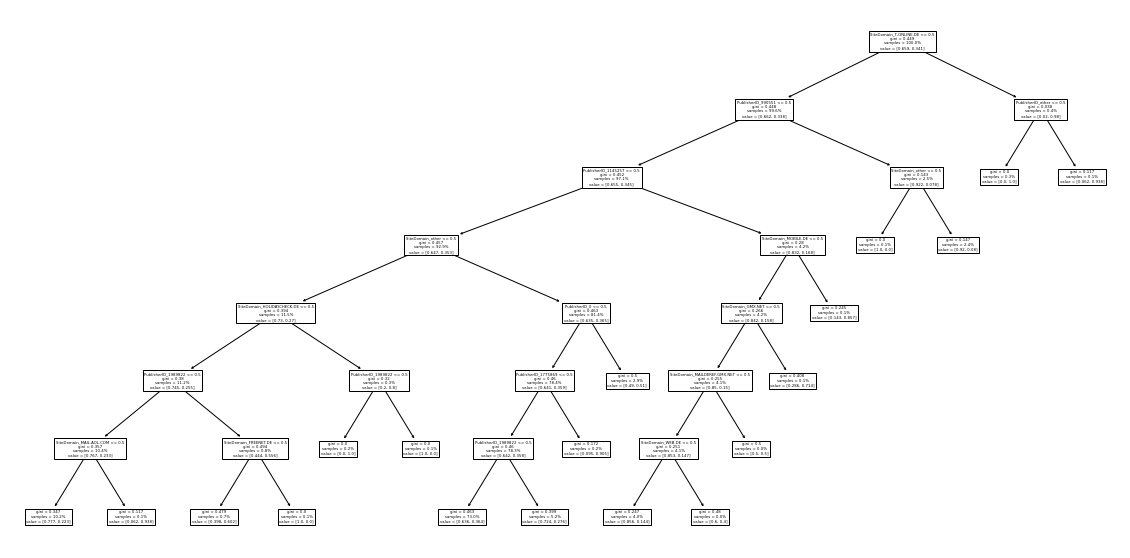

In [27]:
# Nicer visualisation
OHE = model.steps[0][1]
feature_names = OHE.get_feature_names_out() 
pl.figure(figsize = (20,10))
tree.plot_tree(clf, feature_names=feature_names, proportion=True) #, impurity=False)
pl.show()

## Individual trees for each publisher
The above analysis will produce a decision tree - however, the **if-else** statements that will arise from such a tree are extremely complicated. Since the publisher ID are always relevant for viewability, we can have a separate decision tree for each publisher (as a root node), and then later combine the trees into a Bonsai *forest*.

*Die obige Analyse wird einen Decision Tree erzeugen – jedoch sind die **if-else**-Statements, die sich aus einem solchen Tree ergeben, extrem kompliziert. Da die Publisher-ID immer für die Viewability relevant sind, können wir für jeden Publisher einen separaten Decision Tree (als Root-Node) haben und die Trees später zu einem Bonsai-*Wald* kombinieren.*



In [28]:
relevant_publishers = np.unique (df.PublisherID)
print ('List of relevant publishers', relevant_publishers)

List of relevant publishers ['0' '1000494' '1000500' '1000527' '1000533' '1106811' '1120688' '1145257'
 '1285870' '1454503' '1493076' '1527735' '1553526' '1703113' '1760703'
 '1775869' '1775886' '1802193' '1828659' '1866534' '1989822' '990535'
 '990550' '990551' 'other']


Bonsai "Branch" for Publisher0


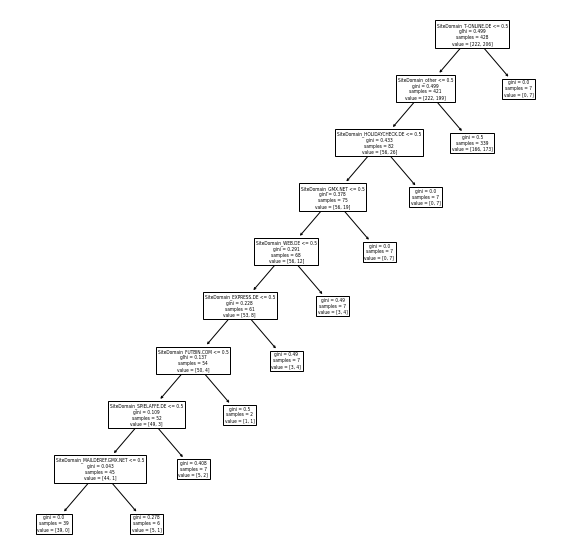

Bonsai "Branch" for Publisher1000494


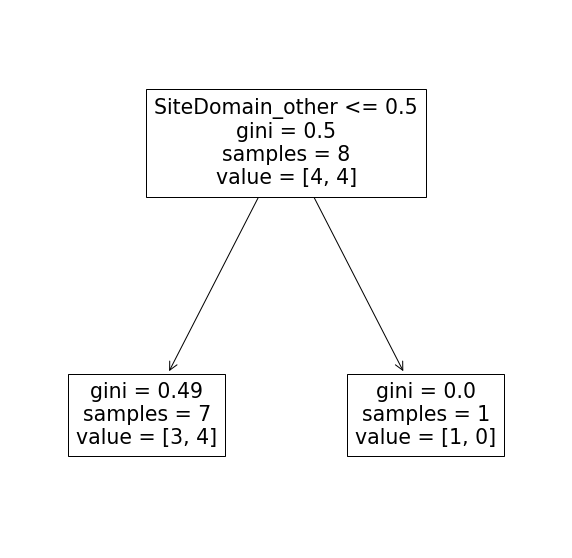

Bonsai "Branch" for Publisher1000500


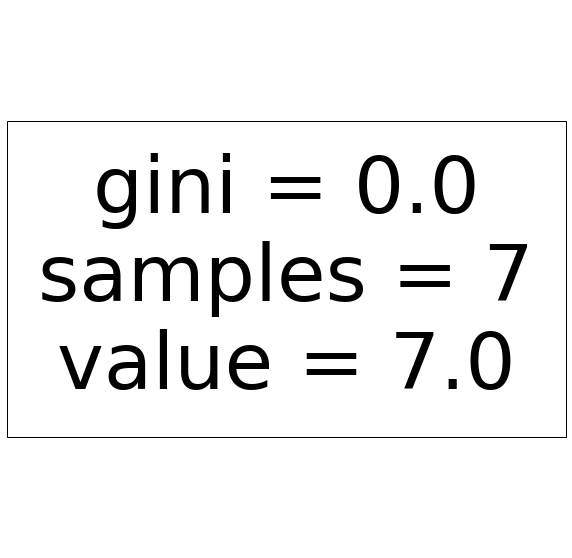

Bonsai "Branch" for Publisher1000527


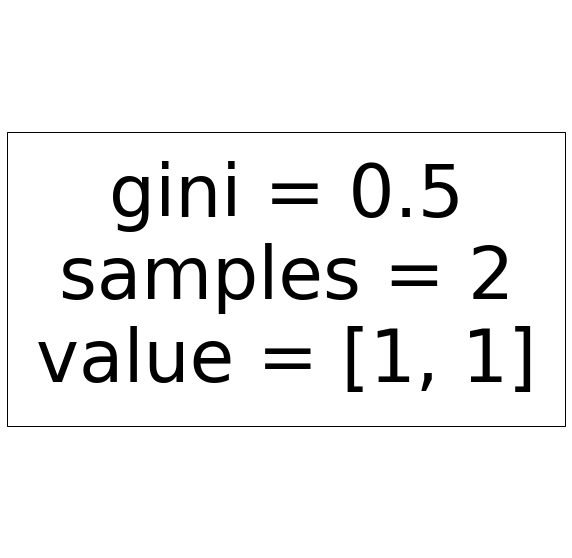

Bonsai "Branch" for Publisher1000533


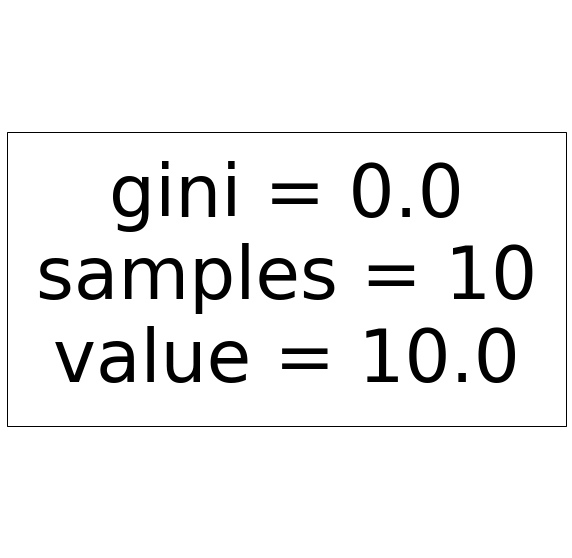

Bonsai "Branch" for Publisher1106811


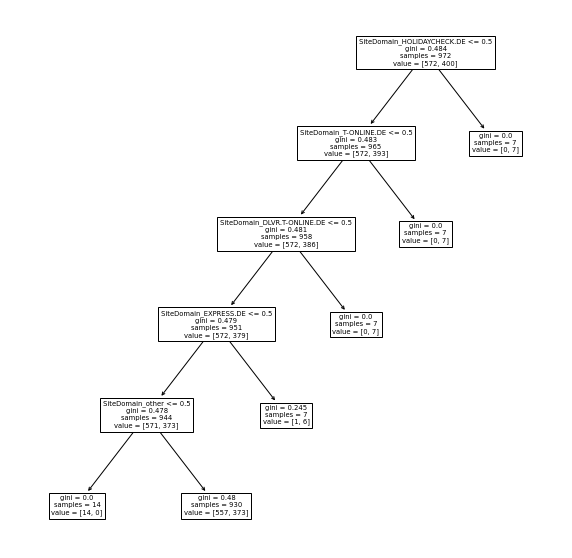

Bonsai "Branch" for Publisher1120688


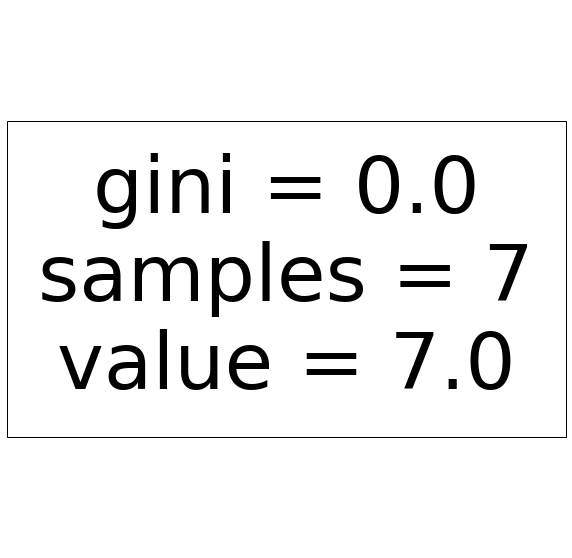

Bonsai "Branch" for Publisher1145257


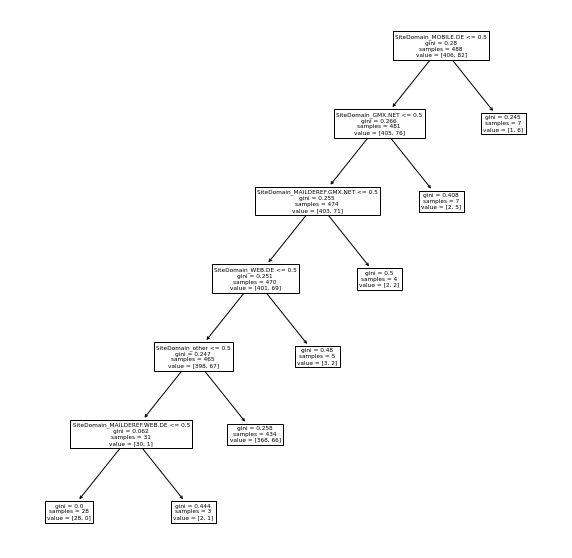

Bonsai "Branch" for Publisher1285870


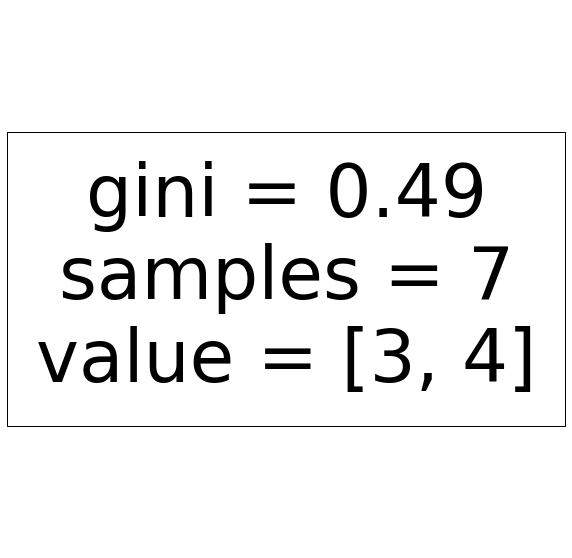

Bonsai "Branch" for Publisher1454503


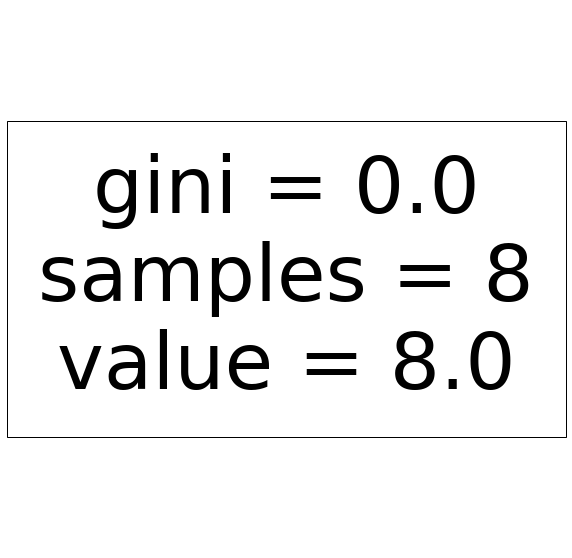

Bonsai "Branch" for Publisher1493076


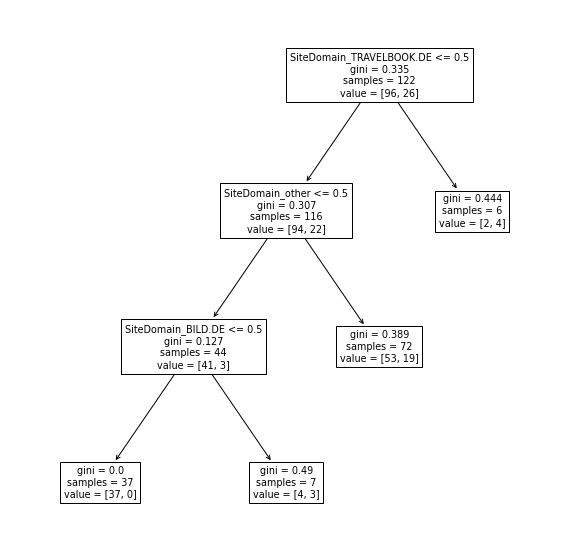

Bonsai "Branch" for Publisher1527735


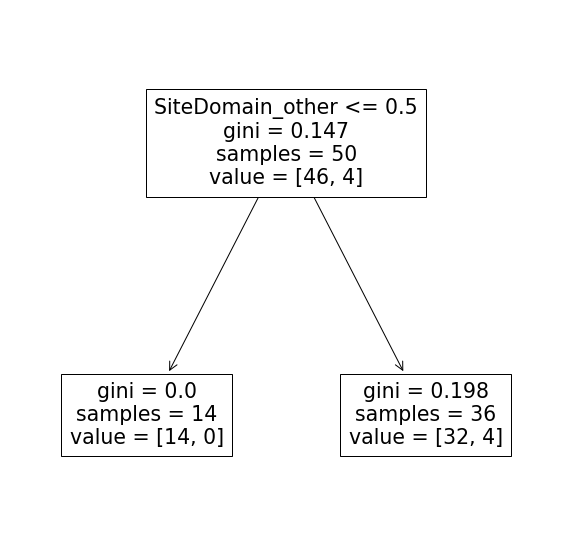

Bonsai "Branch" for Publisher1553526


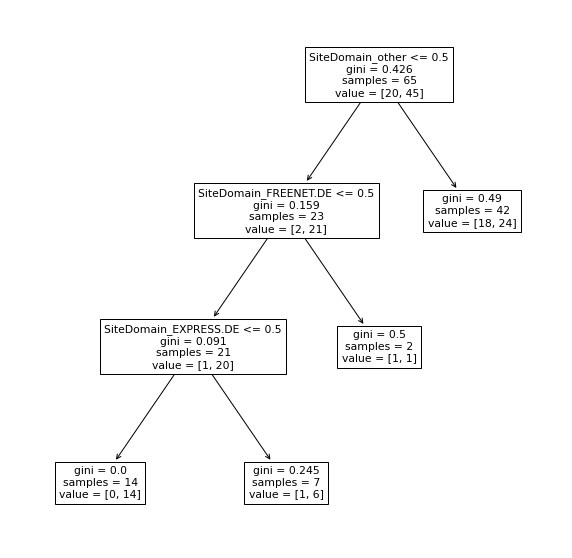

Bonsai "Branch" for Publisher1703113


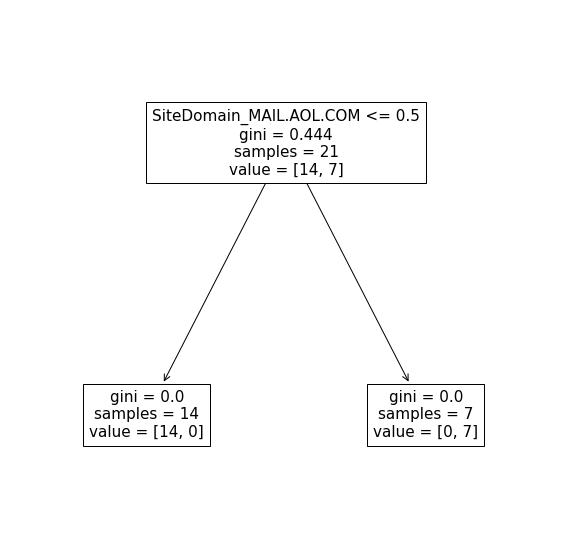

Bonsai "Branch" for Publisher1760703


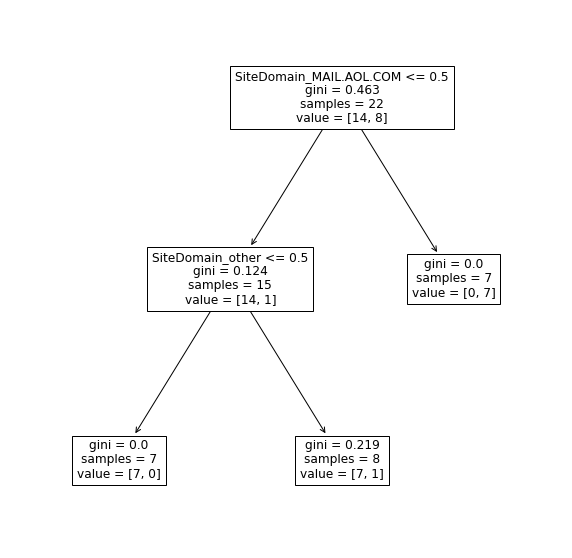

Bonsai "Branch" for Publisher1775869


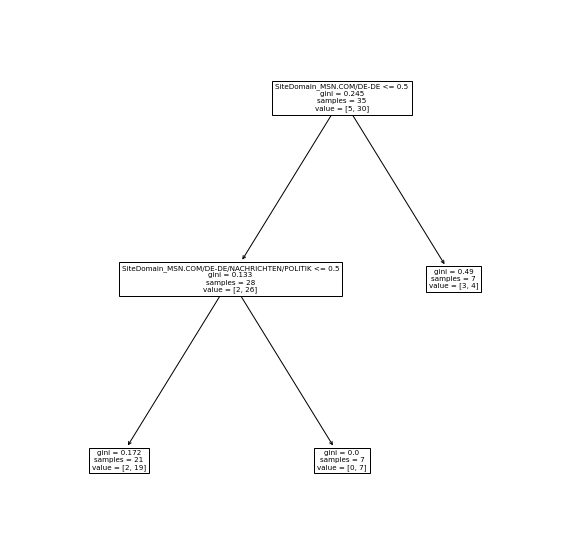

Bonsai "Branch" for Publisher1775886


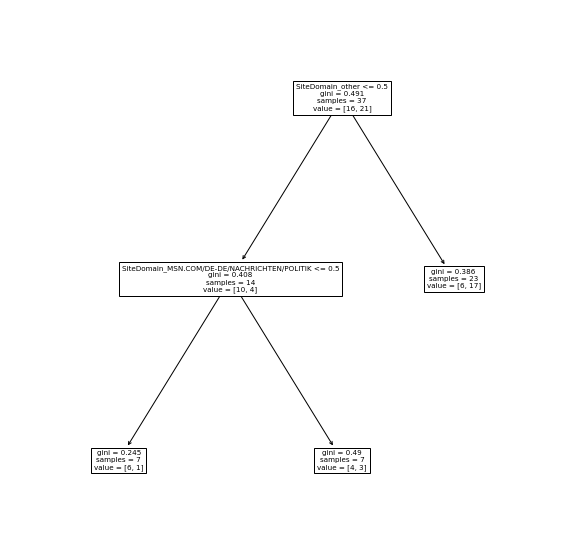

Bonsai "Branch" for Publisher1802193


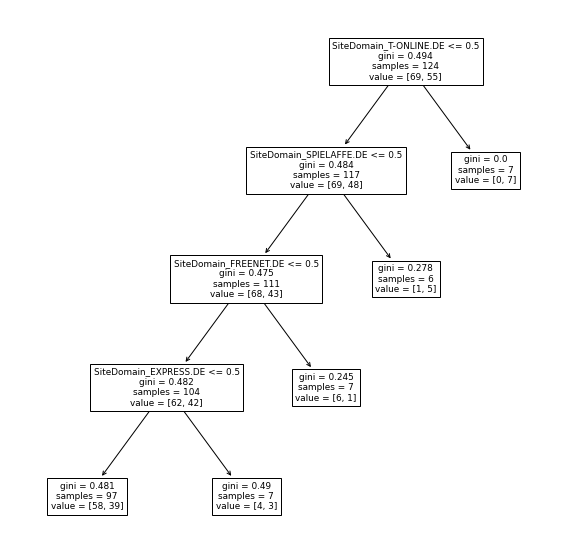

Bonsai "Branch" for Publisher1828659


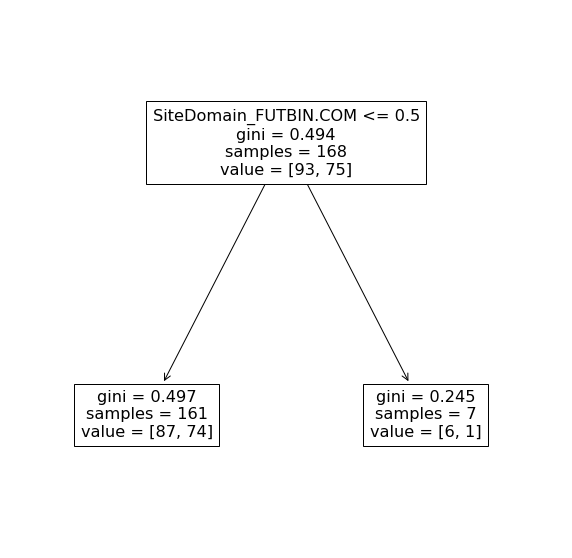

Bonsai "Branch" for Publisher1866534


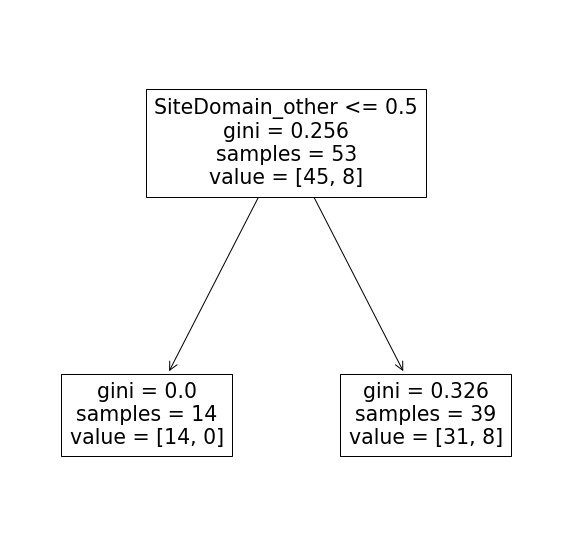

Bonsai "Branch" for Publisher1989822


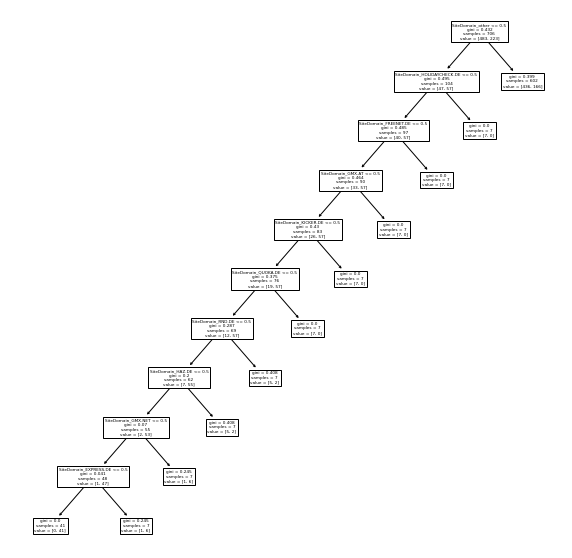

Bonsai "Branch" for Publisher990535


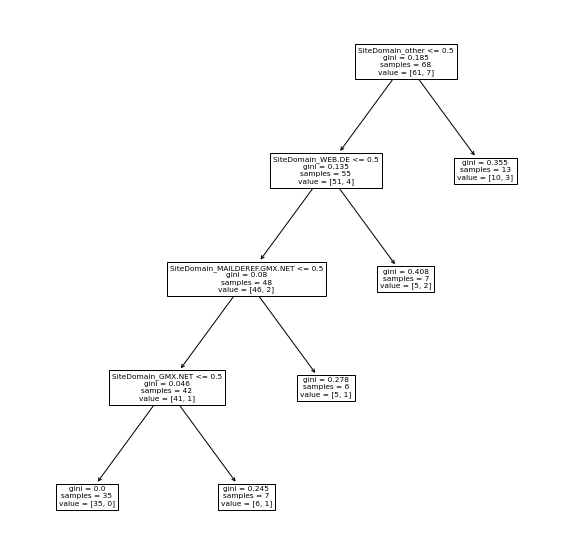

Bonsai "Branch" for Publisher990550


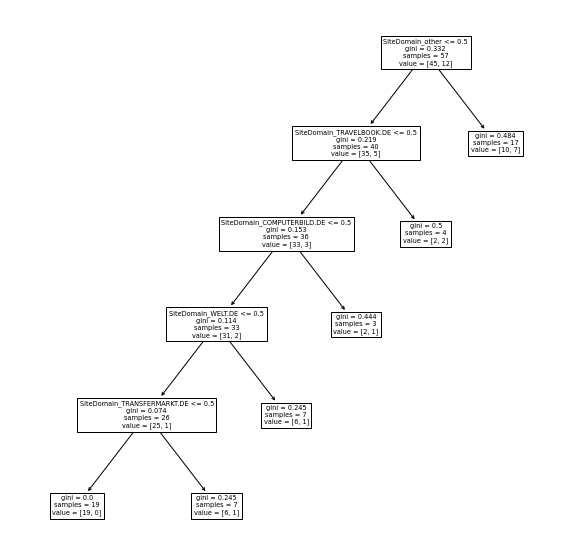

Bonsai "Branch" for Publisher990551


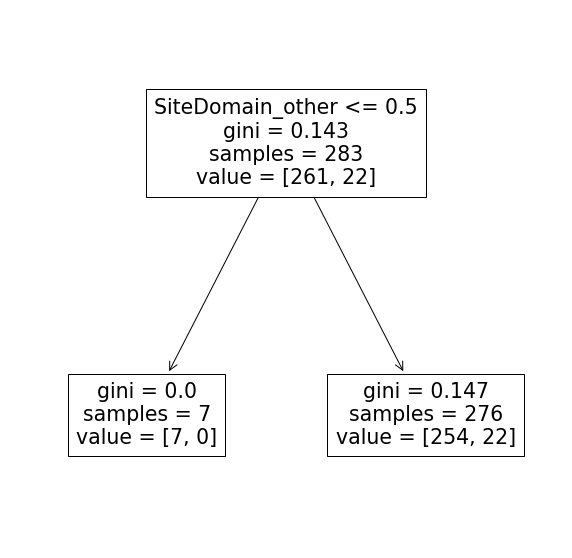

Bonsai "Branch" for Publisherother


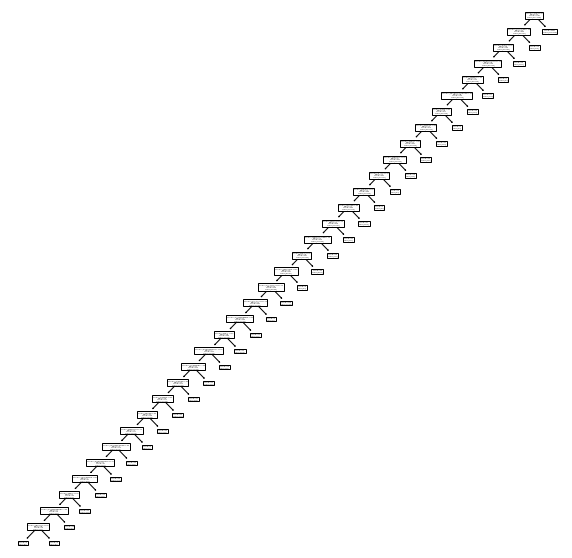

In [30]:
for publisher in relevant_publishers:
    features = ['PublisherID', 'SiteDomain'] # only other feature for now
    label = 'Score'
    publisher_filter = df.PublisherID == publisher

    X = df[features][publisher_filter]
    y = df[label][publisher_filter]
    
    # the depth of the classifier can be arbitrary here
    model= make_pipeline (OneHotEncoder(), DecisionTreeClassifier()) 
    model.fit(X, y)
    OHE = model.steps[0][1]
    OHE_feature_names = OHE.get_feature_names_out() 
    
    clf = model.steps[-1][1]
    print('Bonsai "Branch" for Publisher' + publisher)
    
    pl.figure(figsize = (10,10))
    tree.plot_tree(clf, feature_names=OHE_feature_names) #, proportion=True) #, impurity=False)
    pl.show()


## Things to do next
* Check SQL query (DONE)
* Training/Test split
* Define a real "score" - Score => BidModifier
* Work out how to export the tree to csv/Xandr
* Add 50:1 Viewability as secondary KPI